**The Relationship between Bank Term Subscriptions, Age and Bank Balance**

In [13]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

**Introduction**<br/>
The Bank Marketing dataset was gathered from a direct marketing campaign of a Portuguese baking institution. The bank collected information from their clients over the phone, and each client was contacted multiple times. The Bank Marketing Dataset discusses multiple characteristics of clients of a bank in hopes to predict whether they will subscribe to a term deposit. Variables in the set include age, job, education, marital status, and more.

The question our project aims to answer is: Will new clients subscribe to a bank term deposit or will new clients not subscribe to a bank term deposit? This is achieved through classification and further described below.


**Methods**<br/>
A preliminary data analysis was completed to review the information available to us to work with as well as chose the main predictors to use for the project. 

The dataset was first loaded into R from an external website and converted into a .csv file format to ensure that it can be worked with efficiently. The functions head and tail are utilized below to show snippets of the data to ensure readability. The two columns we are interested in are age and balance which are extracted using the select function.

In [14]:
temp <- tempfile()
temp2 <- tempfile()

# Load the data from source website
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
# Read the data as csv and treat the variable "y(whether client subscribe to term deposit)" as factor
bank_data <- read_csv2(file.path(temp2, "bank.csv")) %>%
    mutate(y = as_factor(y))
unlink(c(temp, temp2))
head(bank_data)
tail(bank_data)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
32,services,single,secondary,no,473,yes,no,cellular,7,jul,624,5,-1,0,unknown,no
33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [18]:
# Extract a data frame from the original data with only the coluumns we are interested in
bank_age_balance <- bank_data %>% select(age,balance,y)
bank_age_balance

# Print the head and tail of the bank_age_balance
head(bank_age_balance)
tail(bank_age_balance)

age,balance,y
<dbl>,<dbl>,<fct>
30,1787,no
33,4789,no
35,1350,no
⋮,⋮,⋮
57,295,no
28,1137,no
44,1136,no


age,balance,y
<dbl>,<dbl>,<fct>
30,1787,no
33,4789,no
35,1350,no
30,1476,no
59,0,no
35,747,no


age,balance,y
<dbl>,<dbl>,<fct>
32,473,no
33,-333,no
57,-3313,no
57,295,no
28,1137,no
44,1136,no


In [19]:
# Splitting the data into training data and testing data
bank_split <- initial_split(bank_age_balance, prop = 0.75, strata = age)  
# We choose 0.75 as the portion of training data because we will perform cross-validation later,
# so the training data set cannot be too small. However we also think that the testing on
# the accuracy of our model is important, so we believe that 0.75 is an appropriate choise.
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)

# Print the head and tail of the training set
head(bank_train)
tail(bank_train)

age,balance,y
<dbl>,<dbl>,<fct>
30,1787,no
35,1350,no
30,1476,no
59,0,no
35,747,no
39,147,no


age,balance,y
<dbl>,<dbl>,<fct>
38,1205,no
32,473,no
33,-333,no
57,295,no
28,1137,no
44,1136,no


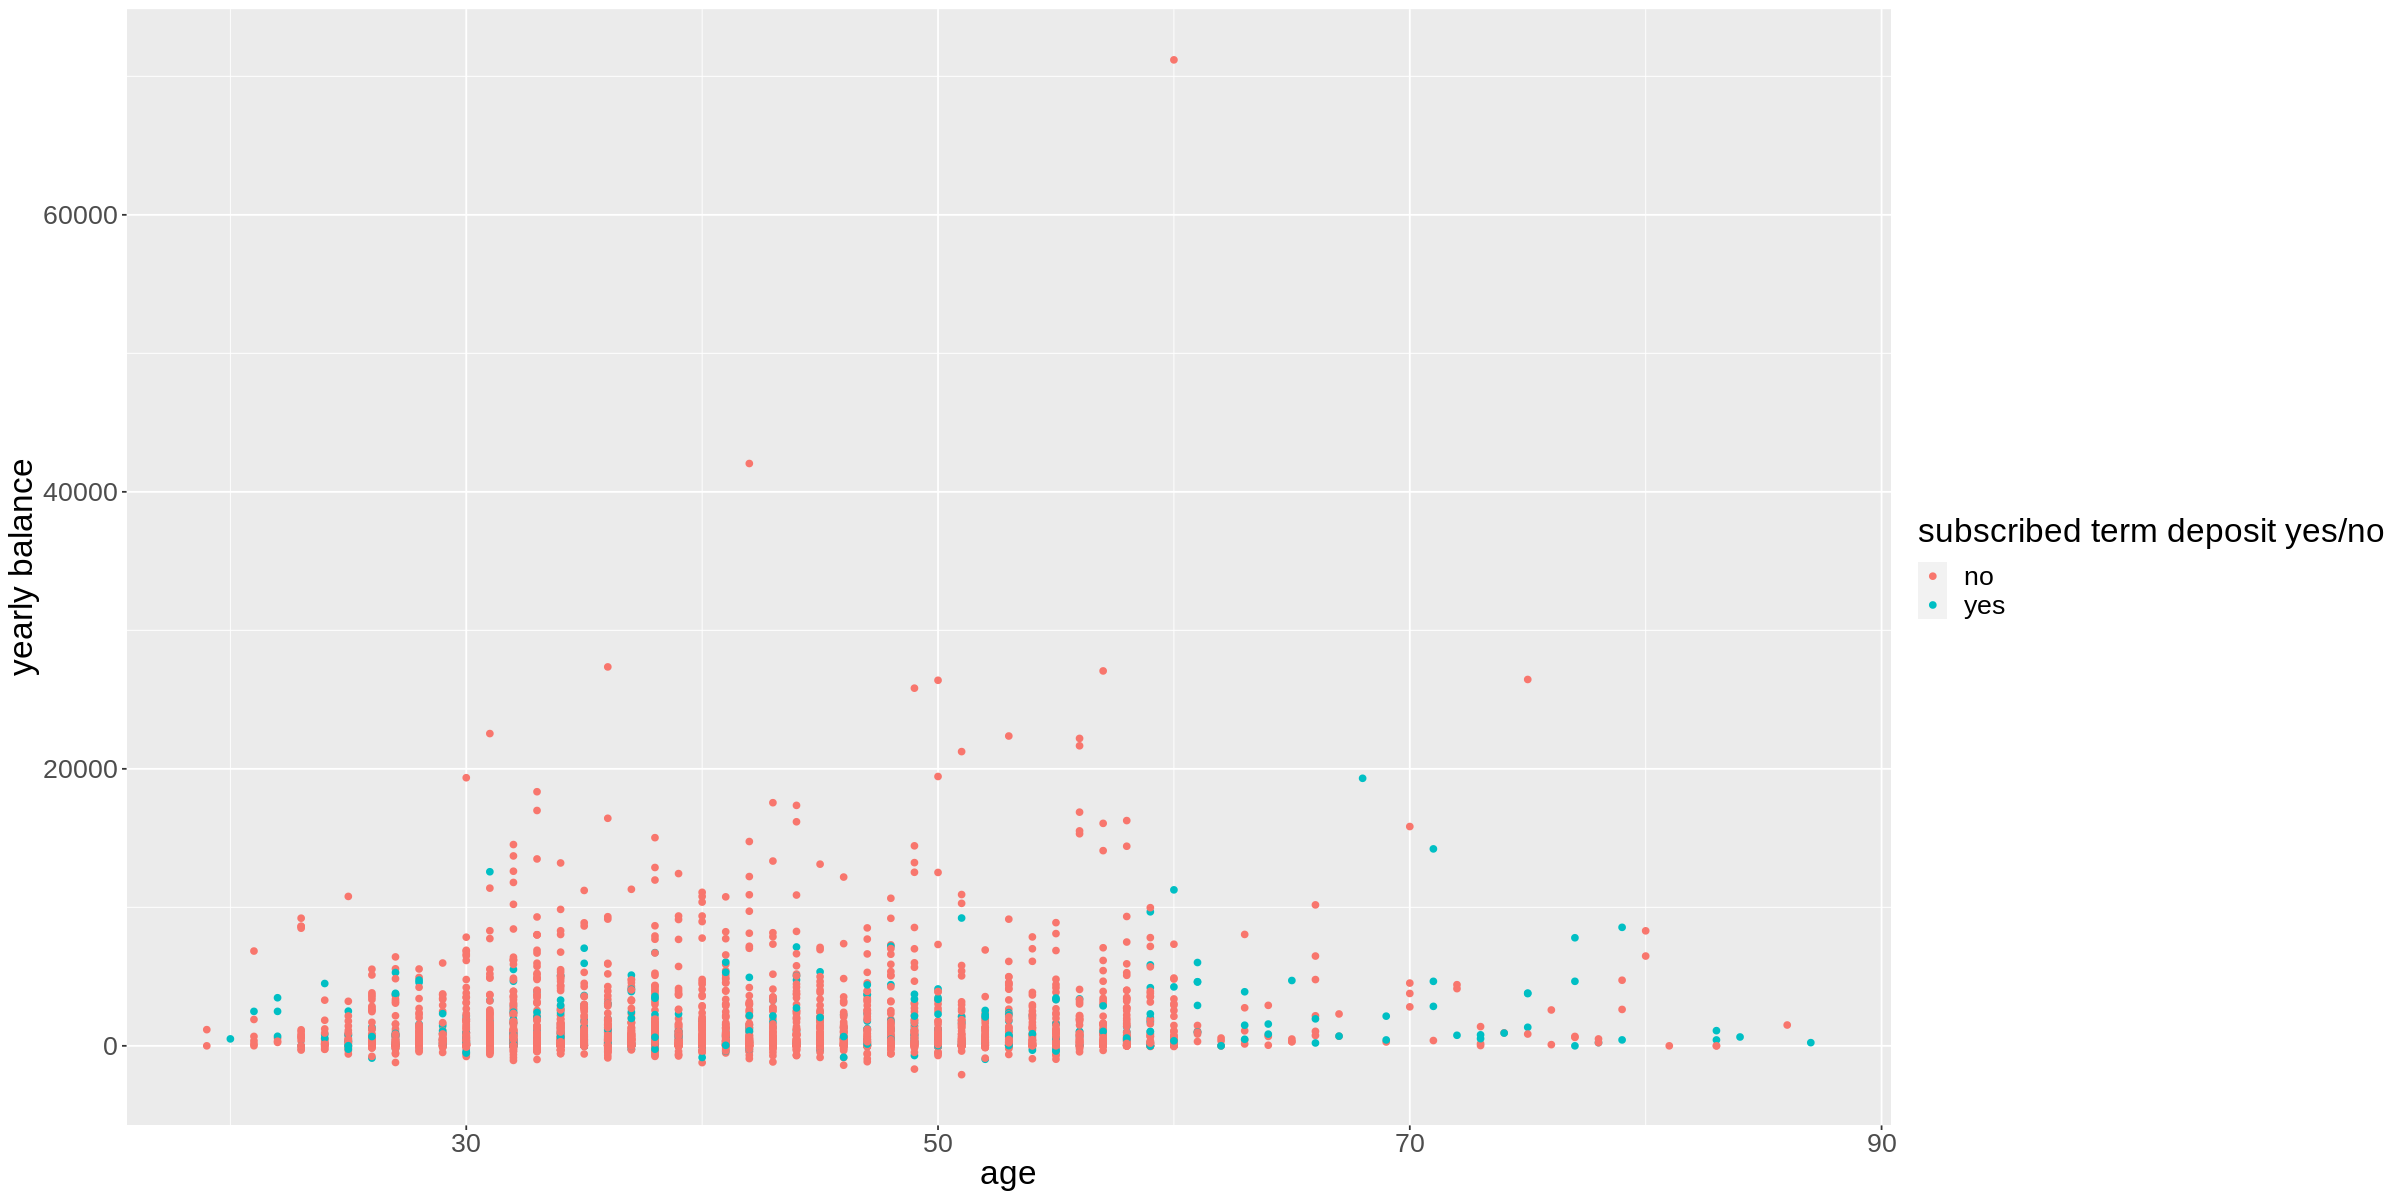

In [29]:
# We first plot a scatterplot on age vs balance
# with the factor y colored on every single points.

options(repr.plot.width = 20, repr.plot.height = 10) 
age_vs_balance_plot <- bank_train %>%
    ggplot(aes(x = age, y = balance)) +
    geom_point(aes(colour = y)) + 
    labs(x = "age", y = "yearly balance",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20))
age_vs_balance_plot

In [69]:
bank_recipe <- recipe(y ~ age + balance, data = bank_train)
bank_recipe 

bank_recipe_scaled <- bank_recipe %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()
bank_recipe_scaled

scaled_bank <- bake(bank_recipe_scaled, bank_train)
scaled_bank

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 3392 data points and no missing data.

Operations:

Scaling for age, balance [trained]
Centering for age, balance [trained]

age,balance,y
<dbl>,<dbl>,<fct>
-1.0551246,0.13091358,no
-0.5825019,-0.01501375,no
-1.0551246,0.02706141,no
⋮,⋮,⋮
1.4970379,-0.36730969,no
-1.2441737,-0.08614080,no
0.2682189,-0.08647473,no


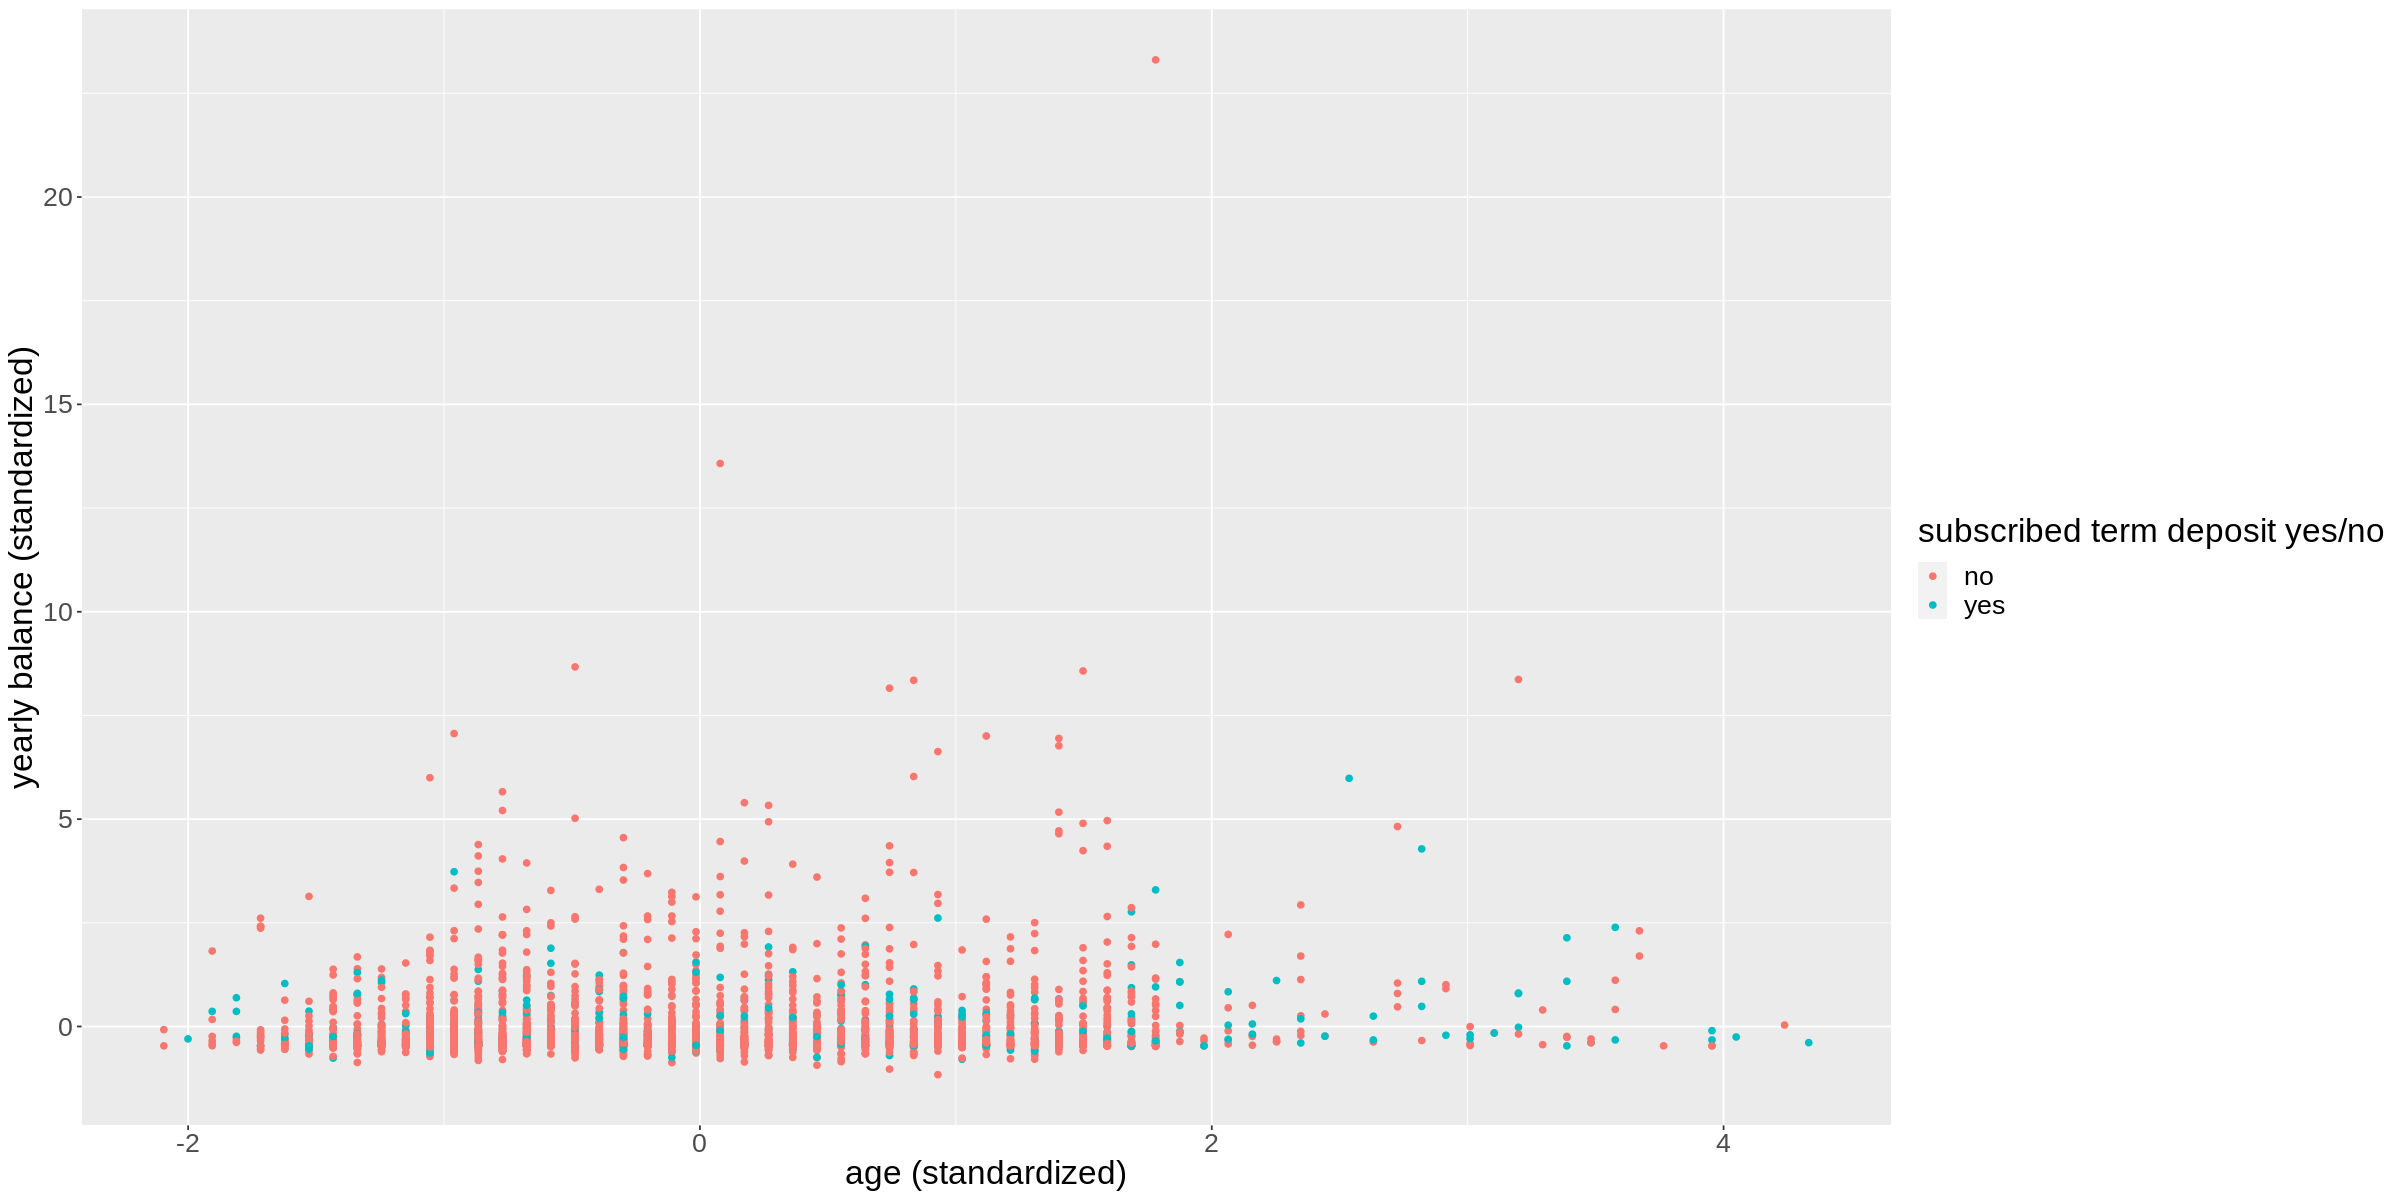

In [76]:
# We first plot a scatterplot on age vs balance
# with the factor y colored on every single points.

options(repr.plot.width = 20, repr.plot.height = 10) 
scaled_age_vs_balance_plot <- scaled_bank %>%
    ggplot(aes(x = age, y = balance)) +
    geom_point(aes(colour = y)) + 
    labs(x = "age (standardized)", y = "yearly balance (standardized)",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20))
scaled_age_vs_balance_plot

In [70]:
# We create our K-nearest neighbour classifier with the training set.
# Here we first randomly choose K=10 and run the process to make sure
# nothing is broken; we will perform cross-validation later and choose
# a better K value.

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(bank_recipe_scaled) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~10, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1164505
Best kernel: rectangular
Best k: 10

In [71]:
# We predict y for the testing set using our model of K=10
bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

# We calculate the accuracy of the model K=10, and the accuracy is 88.2%
bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)
bank_prediction_accuracy

.pred_class,age,balance,y
<fct>,<dbl>,<dbl>,<fct>
no,33,4789,no
no,36,307,no
no,43,264,no
no,31,132,no
no,38,0,no
no,26,543,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.88042516
kap,binary,0.01562954


In [72]:
# We would like to choose a better K value for our K-neighbour classification model,
# so we perform the cross-validation method on our training set.
# We choose to perform 5-fold cross-validation because 10-fold is too time consuming.
bank_vfold <- vfold_cv(bank_train, v = 5, strata = y)

# Instead of specifying a specific K value we insert tune() to keep it as a changing parameter
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
knn_tune

# Here we perform the workflow again with cross-validation method to calculate an accuracy for
# each K value in a reasonable range, and we pick the K value that gives best accuracy
knn_results <- workflow() %>%
      add_recipe(bank_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = bank_vfold, grid = 10) %>%
      collect_metrics()
head(knn_results)

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8071896,5,0.005557232,Model1
2,roc_auc,binary,0.5445068,5,0.008184420,Model1
3,accuracy,binary,0.8537746,5,0.005215227,Model2
3,roc_auc,binary,0.5561163,5,0.004373699,Model2
4,accuracy,binary,0.8534801,5,0.005258983,Model3
4,roc_auc,binary,0.5737809,5,0.010097455,Model3


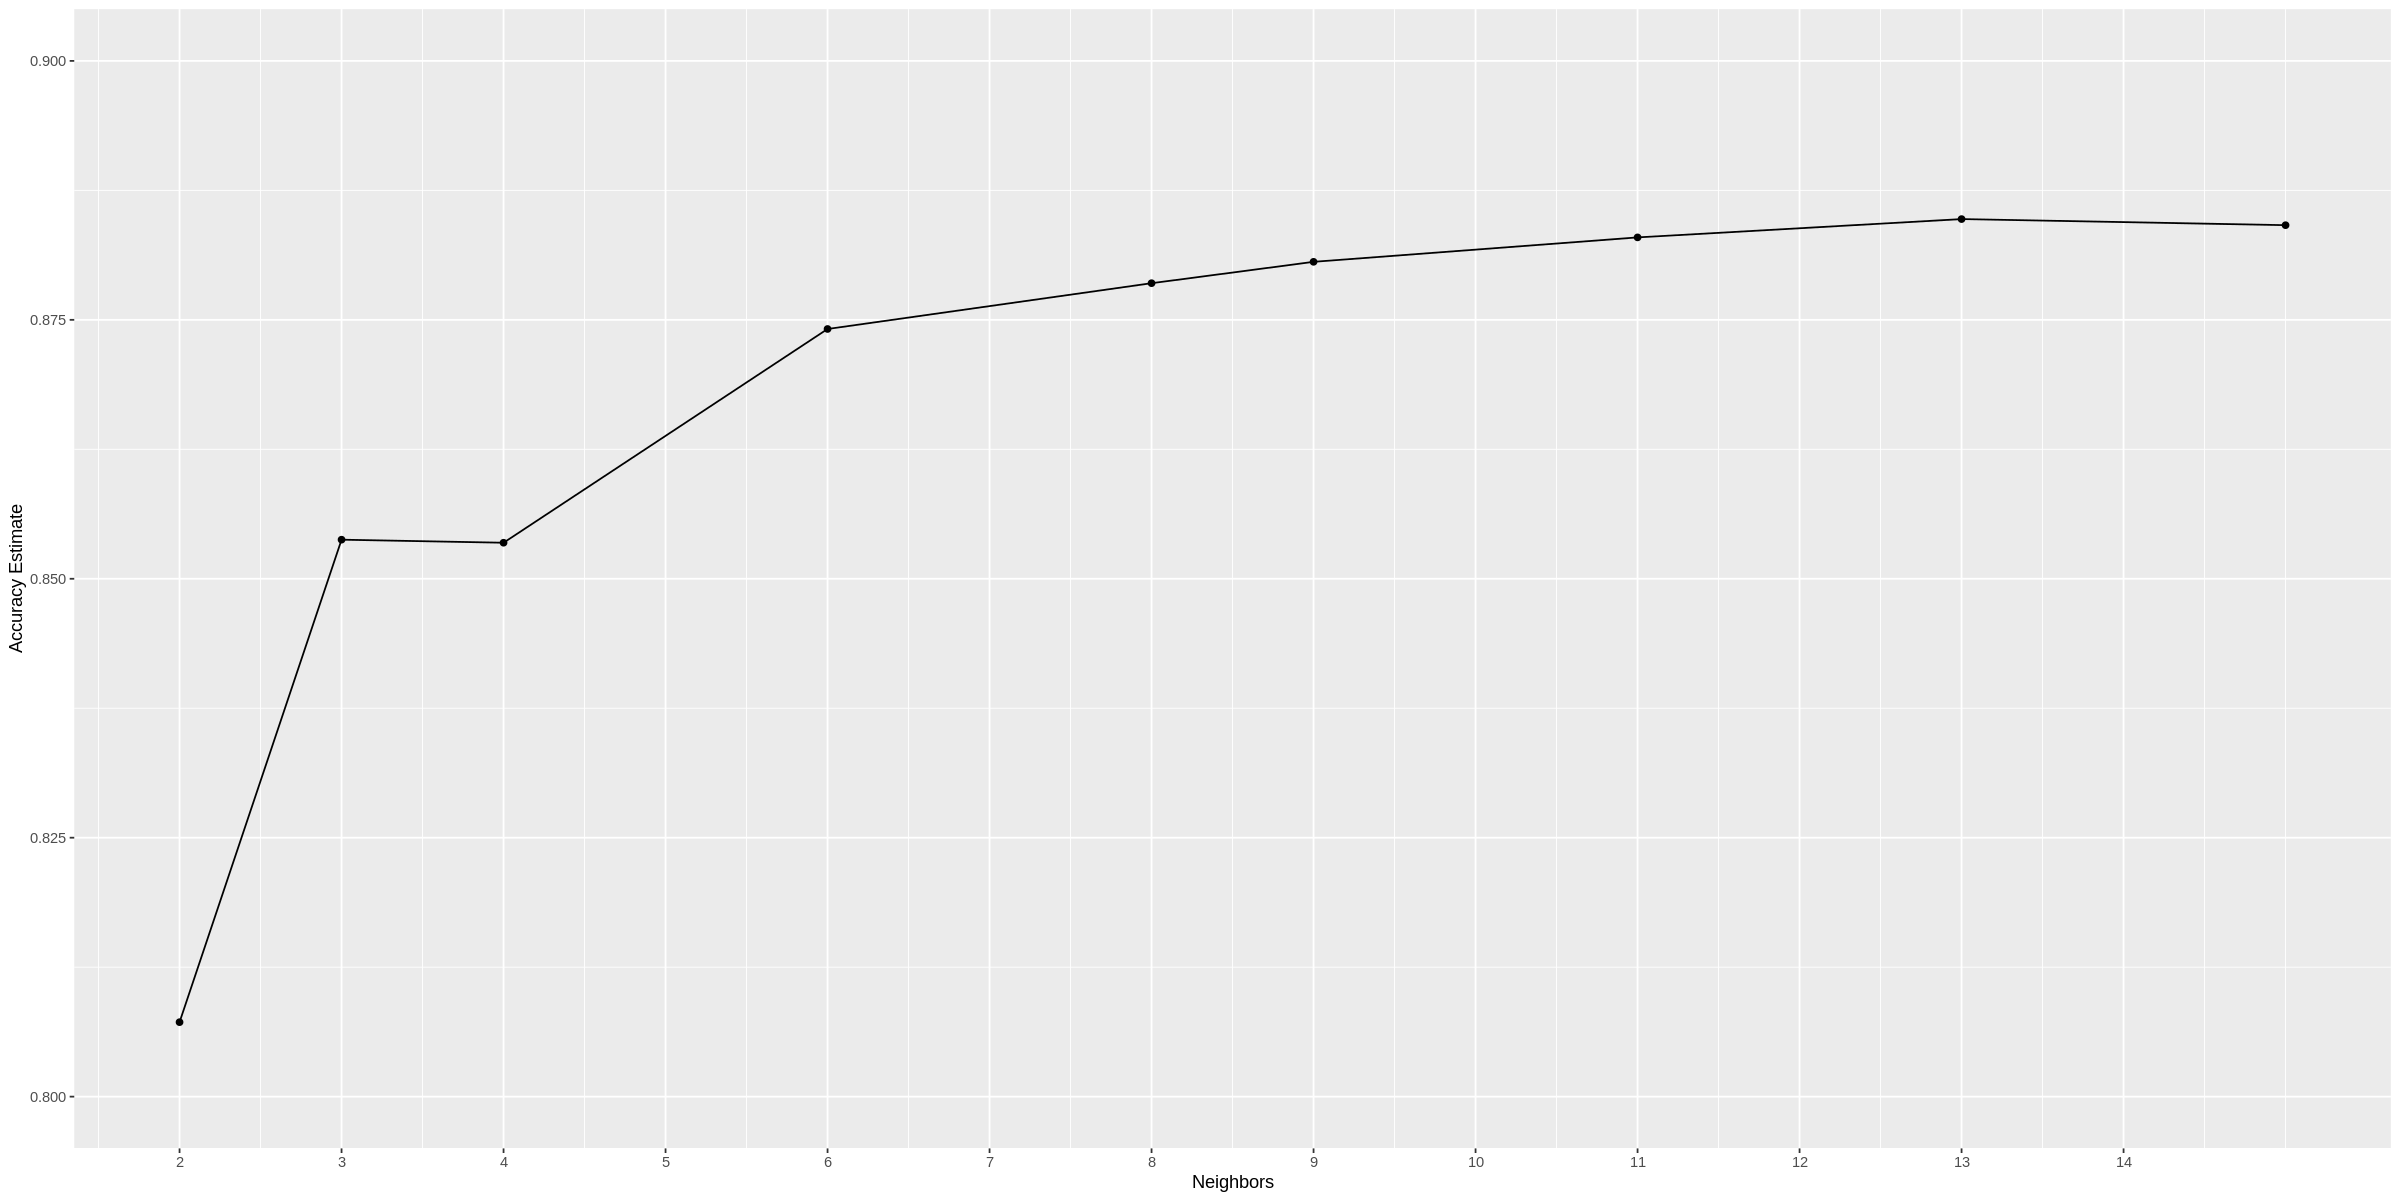

In [74]:
# Filter the accuracy from the .metric column
accuracies <- knn_results %>% 
      filter(.metric=="accuracy")

# Create a plot using the accuracies dataset with K value on the x-axis and estimated accuracy on the y-axis
options(repr.plot.width = 20, repr.plot.height = 10) 
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.8, 0.9)) # adjusting the y-axis

accuracy_versus_k

In [75]:
# From the graph above, K=12 gives the best accuracy, so we perform the whole K-neighbours classification process with K=12

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(bank_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)
bank_prediction_accuracy

# From bank_prediction_accuracy, our model of using age and balance to predict y have accuracy of 88.4%

.pred_class,age,balance,y
<fct>,<dbl>,<dbl>,<fct>
no,33,4789,no
no,36,307,no
no,43,264,no
no,31,132,no
no,38,0,no
no,26,543,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.881310895
kap,binary,0.006227255


**Results**<br/>

**Discussion: Expected Outcomes & Significance**

**References**